# Data Analysis

In [1]:
%matplotlib notebook
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from mpmath import mp, mpf, sin, cos, sqrt, acos


from pathlib import Path
pathtohere = Path.cwd()
print(pathtohere)

C:\Users\02dba\Documents\GitHub\Diatomic-Molecule-Dissociation-by-Gravitational-Gradient\contents


<IPython.core.display.Javascript object>


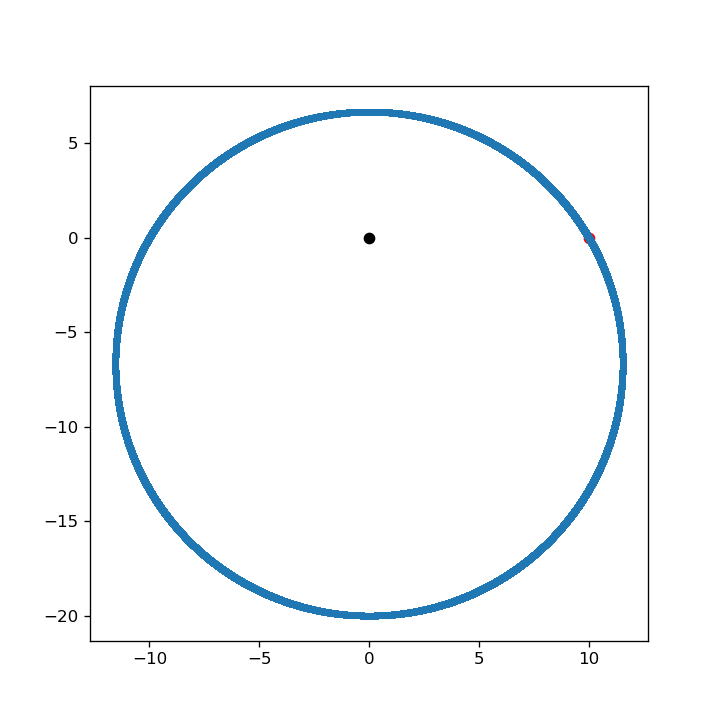

[10.          9.995       9.99000001  9.98500002  9.98000005]


In [2]:
numSteps = int(1e+5)
L = 1e+1
M = 1e+1

rs = np.zeros(numSteps)
phis = np.zeros_like(rs)
phis[0] = 0.
rs[0] = 10.
dt = 1e-2
r_dot = -5e-1

rs[1] = rs[0] + dt*r_dot + dt*dt*(L*L/(rs[0]*rs[0]*rs[0]) - M/(rs[0]*rs[0]))


# Set r_dot = 0 by energy.
energy = 0.5* (r_dot*r_dot + L*L/(rs[0]*rs[0])) - M/rs[0]




for step in range(1,numSteps-1):
    rs[step+1] = 2*rs[step] - rs[step-1] + dt*dt*(L*L/(rs[step]*rs[step]*rs[step]) - M/(rs[step]*rs[step]))


    phis[step+1] = phis[step] + dt*L/(rs[step]*rs[step])
    
    
   
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(0,0,c='k')
ax.scatter(rs[0]*np.cos(phis[0]), rs[0]*np.sin(phis[0]), c='r', marker='o')
ax.plot(rs*np.cos(phis), rs*np.sin(phis), marker='.')


plt.show()


print(rs[:5])

In [3]:
epsilon_0 = 1. / (4.*np.pi) # Geometrised-Gaussian units
mp.dps = 25  # Decimal places of precision

In [4]:
class BlackHole:
    mass = 0.
    a = 0.
    l = 0.
    charge = 0.
    
class Particle:
    mass = 0.
    charge = 0. # electric charge
    energy = 0.
    L = 0. # angular momentum


def readPropertiesFile():
    """
    Read the properties file and save the variables.
    
    Outputs:
        - BH: Instance of the black hole.
        - particle: Instance of the particle.
        - moleculeLength:float: The average molecule length.
    """
    
    BH = BlackHole()
    particle = Particle()
    
    kg_to_m = 1. / 1.3466e+27
    eV_to_m = 1.602176634e-19 / 1.2102e+44
    e_to_1 = 1.602176634e-19 / 5.2909e-19
    s_to_m = 1. / 3.3356e-9
    sol_to_m = 1.98855e+30 * kg_to_m
    
    line = True
    filePath = pathtohere / 'data/properties.txt'
    i = 0
    maxFileSize = 1_000
    # https://stackoverflow.com/questions/3277503/how-to-read-a-file-line-by-line-into-a-list
    with open(filePath, 'r', encoding='UTF-8') as f:
        while line and i < maxFileSize:
            line = f.readline()
            

            if (line[:-1] == "# particle mass [double] [u]"):
                line = f.readline()
                i += 1;
                particle.mass = kg_to_m*1.66053906892e-27*float(line)
            elif (line[:-1] == "# particle epsilon [double] [meV]"):
                line = f.readline()
                i += 1;
                particle.epsilon = eV_to_m*1e-3*float(line)
            elif (line[:-1] == "# particle sigma [double] [nm]"):
                line = f.readline()
                i += 1;
                particle.sigma = 1e-9*float(line)
            elif (line[:-1] == "# particle electric charge [double] [e]"):
                line = f.readline()
                i += 1
                particle.charge = e_to_1*float(line)
            elif (line[:-1] == "# particle start time [double] [s]"):
                line = f.readline()
                i += 1
                startTime1 = s_to_m*float(line)
            elif (line[:-1] == "# particle start radius [double] [Gm]"):
                line = f.readline()
                i += 1
                startRadius1 = 1e+9*float(line)
            elif (line[:-1] == "# particle start phi [double] [rad]"):
                line = f.readline()
                i += 1
                startPhi1 = float(line)
            elif (line[:-1] == "# particle start theta [double] [rad]"):
                line = f.readline()
                i += 1
                startTheta1 = float(line)

            # Black hole properties
            elif (line[:-1] == "# Black hole mass [double] [sol]"):
                line = f.readline()
                i += 1
                BH.mass = sol_to_m*float(line)
            elif (line[:-1] == "# Black hole Kerr parameter (a) [double]"):
                line = f.readline()
                i += 1
                BH.a = float(line)
            elif (line[:-1] == "# Black hole gravitomagnetic monopole moment (l) [double] [A m]"):
                line = f.readline()
                i += 1
                BH.l = float(line)
            elif (line[:-1] == "# Black hole electric charge (Q) [double] [e]"):
                line = f.readline()
                i += 1
                BH.charge = e_to_1*float(line)

            elif (line == "\n" or line==''):
                continue
            else:
                raise Exception("Unrecognised line in properties file:",line)
            
            
            i += 1

            if i >= maxFileSize:
                raise Exception(f'Unsafe file size: number of lines exceeds {maxFileSize}.')
                
    moleculeLength = 1.12246204831 * particle.sigma
                
                
    return BH, particle, moleculeLength

In [5]:
def displaySystem(BH, coords1:np.ndarray, coords2:np.ndarray, isPrecise:bool=True):
    """
    Display the particle(')s(') motion through the system.
    
    Inputs:
        - BH: Instance of the black hole.
        - coords1:np.ndarray: History of the coordinates of particle 1.
        - coords2:np.ndarray: History of the coordinates of particle 2.
        - isPrecise:bool: Whether to use the ultra precise measurements.
    """
    
    r_Q2 = BH.charge*BH.charge / (4*np.pi*epsilon_0)
    r_s = 2.*BH.mass
    
    fig = plt.figure(figsize=(6,6), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    
    # Sphere mesh.
    phi = np.linspace(0, 2 * np.pi, 100)
    theta = np.linspace(0, np.pi, 100)
    x = np.cos(phi)[:, None] * np.sin(theta)[None,:]
    y = np.sin(phi)[:,None] * np.sin(theta)[None,:]
    z = np.ones(np.size(phi))[:,None] * np.cos(theta)[None,:]
    
    # Inner horizon
    r = r_s / 2. - np.sqrt(r_s*r_s / 4. - BH.a*BH.a - r_Q2)
    ax.plot_surface(r * x, r * y, r * z, color='black', alpha=0.2)
    print(f'Inner horizon: {r}')
    # Outer horizon
    r = r_s / 2. + np.sqrt(r_s*r_s / 4. - BH.a*BH.a - r_Q2)
    ax.plot_surface(r * x, r * y, r * z, color='m', alpha=0.2)
    print(f'Outer horizon: {r}')
    
    # Inner ergosphere
    r = r_s / 2. - np.sqrt(r_s*r_s / 4. - BH.a*BH.a*np.cos(theta)*np.cos(theta) - r_Q2)
    ax.plot_surface(r[None,:] * x, r[None,:] * y, r[None,:] * z, color='cyan', alpha=0.2)
    print(f'Inner ergosphere: [{r.min()},{r.max()}]')
    # Outer ergosphere
    r = r_s / 2. + np.sqrt(r_s*r_s / 4. - BH.a*BH.a*np.cos(theta)*np.cos(theta) - r_Q2)
    ax.plot_surface(r[None,:] * x, r[None,:] * y, r[None,:] * z, color='yellow', alpha=0.2)
    print(f'Outer ergosphere: [{r.min()},{r.max()}]')
    
    if not isPrecise:
        # Particle1 trajectory.
        x1 = coords1[:,2] * np.sin(coords1[:,4]) * np.cos(coords1[:,3])
        y1 = coords1[:,2] * np.sin(coords1[:,4]) * np.sin(coords1[:,3])
        z1 = coords1[:,2] * np.cos(coords1[:,4])

        # Particle2 trajectory.
        x2 = coords2[:,2] * np.sin(coords2[:,4]) * np.cos(coords2[:,3])
        y2 = coords2[:,2] * np.sin(coords2[:,4]) * np.sin(coords2[:,3])
        z2 = coords2[:,2] * np.cos(coords2[:,4])
        
    else:
        x1 = np.array([c2 * sin(c4) * cos(c3) 
                      for c2, c4, c3 in zip(coords1[:,2], coords1[:,4], coords1[:,3])], dtype=object)
        y1 = np.array([c2 * sin(c4) * sin(c3) 
                      for c2, c4, c3 in zip(coords1[:,2], coords1[:,4], coords1[:,3])], dtype=object)
        z1 = np.array([c2 * cos(c4) 
                      for c2, c4 in zip(coords1[:,2], coords1[:,4])], dtype=object)
        
        x2 = np.array([c2 * sin(c4) * cos(c3) 
                      for c2, c4, c3 in zip(coords2[:,2], coords2[:,4], coords2[:,3])], dtype=object)
        y2 = np.array([c2 * sin(c4) * sin(c3) 
                      for c2, c4, c3 in zip(coords2[:,2], coords2[:,4], coords2[:,3])], dtype=object)
        z2 = np.array([c2 * cos(c4) 
                      for c2, c4 in zip(coords2[:,2], coords2[:,4])], dtype=object)
        
    ax.scatter(x1,y1,z1, c='b', marker='.',s=1.)
    ax.scatter(x2,y2,z2, c='g', marker='.',s=1.)
    
    
    # Create appropiate labels.
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    # Limit graph size.
    size = 1.1*coords1[0,1]
#     ax.set_xlim(-size, size)
#     ax.set_ylim(-size, size)
#     ax.set_zlim(-size, size)
    
    plt.show()
    
    
def displayCoordinateStats(BH, coords1:np.ndarray, coords2:np.ndarray, isPrecise:bool=True):
    """
    Display how each the coordinates changes for both particles.
   
    Inputs:
        - BH: Instance of the black hole.
        - coords1:np.ndarray: History of the coordinates of particle 1.
        - coords2:np.ndarray: History of the coordinates of particle 2.
        - isPrecise:bool: Whether to use the ultra precise measurements.
    """
    
    r_Q2 = BH.charge*BH.charge / (4*np.pi*epsilon_0)
    r_s = 2.*BH.mass
    
    lambdas = coords1[:,0]
    coords = (coords1[:,1:] + coords2[:,1:]) / 2.
    
    colours = ('r','g','b','m')
    ylabels = ('t','r',r'$\phi$',r'$\theta$')
    
    
    fig = plt.figure(figsize=(8,8), tight_layout=True)
    
    for i in range(4):
        ax = fig.add_subplot(2,2,i+1)
        ax.scatter(lambdas, coords[:,i], marker='.',c=colours[i])
        if i==1:
            if not isPrecise:
                r_erg = r_s / 2. + np.sqrt(r_s*r_s / 4. - BH.a*BH.a*np.cos(coords[:,3])*np.cos(coords[:,3]) - r_Q2)
            else:
                r_erg = r_s / 2. + np.array([sqrt(r_s*r_s / 4. - BH.a*BH.a*cos(c3)*cos(c3) - r_Q2)
                      for c3 in coords[:,3]], dtype=object)
            
            r_eventHorizon = r_s / 2. + np.sqrt(r_s*r_s / 4. - BH.a*BH.a - r_Q2)
            
            ax.plot(lambdas,r_erg,c='y')
            ax.axhline(r_eventHorizon,c='m')
        
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(ylabels[i])
        
    plt.show()
    
    
def displayMoleculeAngle(coords1:np.ndarray, coords2:np.ndarray,
                         moleculeLength:float, isPrecise:bool=True):
    """
    Display how the moleculear angle and length vary.
    
    
    Inputs:
        - coords1:np.ndarray: History of the coordinates of particle 1.
        - coords2:np.ndarray: History of the coordinates of particle 2.
        - moleculeLength:float: The average molecule length.
        - isPrecise:bool: Whether to use the ultra precise measurements.
    """
    
    
    if not isPrecise:
        # Particle1 trajectory.
        x1 = coords1[:,2] * np.sin(coords1[:,4]) * np.cos(coords1[:,3])
        y1 = coords1[:,2] * np.sin(coords1[:,4]) * np.sin(coords1[:,3])
        z1 = coords1[:,2] * np.cos(coords1[:,4])

        # Particle2 trajectory.
        x2 = coords2[:,2] * np.sin(coords2[:,4]) * np.cos(coords2[:,3])
        y2 = coords2[:,2] * np.sin(coords2[:,4]) * np.sin(coords2[:,3])
        z2 = coords2[:,2] * np.cos(coords2[:,4])
        
    else:
        x1 = np.array([c2 * sin(c4) * cos(c3) 
                      for c2, c4, c3 in zip(coords1[:,2], coords1[:,4], coords1[:,3])], dtype=object)
        y1 = np.array([c2 * sin(c4) * sin(c3) 
                      for c2, c4, c3 in zip(coords1[:,2], coords1[:,4], coords1[:,3])], dtype=object)
        z1 = np.array([c2 * cos(c4) 
                      for c2, c4 in zip(coords1[:,2], coords1[:,4])], dtype=object)
        
        x2 = np.array([c2 * sin(c4) * cos(c3) 
                      for c2, c4, c3 in zip(coords2[:,2], coords2[:,4], coords2[:,3])], dtype=object)
        y2 = np.array([c2 * sin(c4) * sin(c3) 
                      for c2, c4, c3 in zip(coords2[:,2], coords2[:,4], coords2[:,3])], dtype=object)
        z2 = np.array([c2 * cos(c4) 
                      for c2, c4 in zip(coords2[:,2], coords2[:,4])], dtype=object)
    
    COM = np.asarray([x1+x2, y1+y2, z1+z2]) / 2.
    delta = np.asarray([x2-x1, y2-y1, z2-z1])
    
    if not isPrecise:
        angle = np.arccos((COM[0]*delta[0] + COM[1]*delta[1] + COM[2]*delta[2]) 
                          / linalg.norm(COM, axis=0) / linalg.norm(delta, axis=0))
        
    else:
        # Compute the dot product of COM and delta
        dot_product = sum(c * d for c, d in zip(COM, delta))

        # Compute the norms of COM and delta
        norm_COM = np.array([sqrt(s) for s in sum(c*c for c in COM)], dtype=object)
        norm_delta = np.array([sqrt(s) for s in sum(d*d for d in delta)], dtype=object)

        # Compute the cosine argument
        cos_argument = dot_product / (norm_COM * norm_delta)

        # Compute the arccosine using mpmath.acos
        # Ensure the value is within the valid range for acos
        cos_argument = np.array([max(-1, m) for m in [min(1, n) for n in cos_argument]],
                                dtype=object)  # Clamp value to [-1, 1]

        # Calculate the angle in radians
        angle = np.array([acos(a) for a in cos_argument], dtype=object)
    
    fig = plt.figure(figsize=(8,10), tight_layout=True)
    
    
    # Angular.
    ax = fig.add_subplot(2,1,1)
    ax.scatter(coords1[:,0], angle, c='c', marker='.')
    ax.grid()
    
    #ax.set_ylim(0, np.pi)
    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel(r'angle out of radial axis')
    
    # Separation.
    ax = fig.add_subplot(2,1,2)
    if not isPrecise:
        ax.scatter(coords1[:,0], linalg.norm(delta,axis=0), c='lime', marker='.')
    else:
        ax.scatter(coords1[:,0], norm_delta, c='lime', marker='.')
    ax.grid()
    ax.axhline(moleculeLength, c='r')
    
    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel(r'molecule length')
    
    plt.show()
        
    
    
    

In [6]:
def main():
    
    BH, particle1, moleculeLength = readPropertiesFile()
    particle1Coords = np.loadtxt(pathtohere / 'data/coords1.txt', delimiter=',', dtype=str)
    particle2Coords = np.loadtxt(pathtohere / 'data/coords2.txt', delimiter=',', dtype=str)

    
    # Convert the loaded data to high-precision floats
    high_precision_coords1 = np.array([mpf(x) for x in particle1Coords.flatten()], dtype=object)
    high_precision_coords2 = np.array([mpf(x) for x in particle2Coords.flatten()], dtype=object)

    # If the data is multi-dimensional, reshape it
    particle1Coords = high_precision_coords1.reshape(particle1Coords.shape)
    particle2Coords = high_precision_coords2.reshape(particle2Coords.shape)
    
    
    
    
    print(particle1Coords.shape)
    displaySystem(BH, particle1Coords, particle2Coords)
    
    displayCoordinateStats(BH,particle1Coords, particle2Coords)
    displayMoleculeAngle(particle1Coords, particle2Coords, moleculeLength)
    
    print(particle1Coords[:10, 2], particle2Coords[:10,2])
    

(1000, 5)


<IPython.core.display.Javascript object>


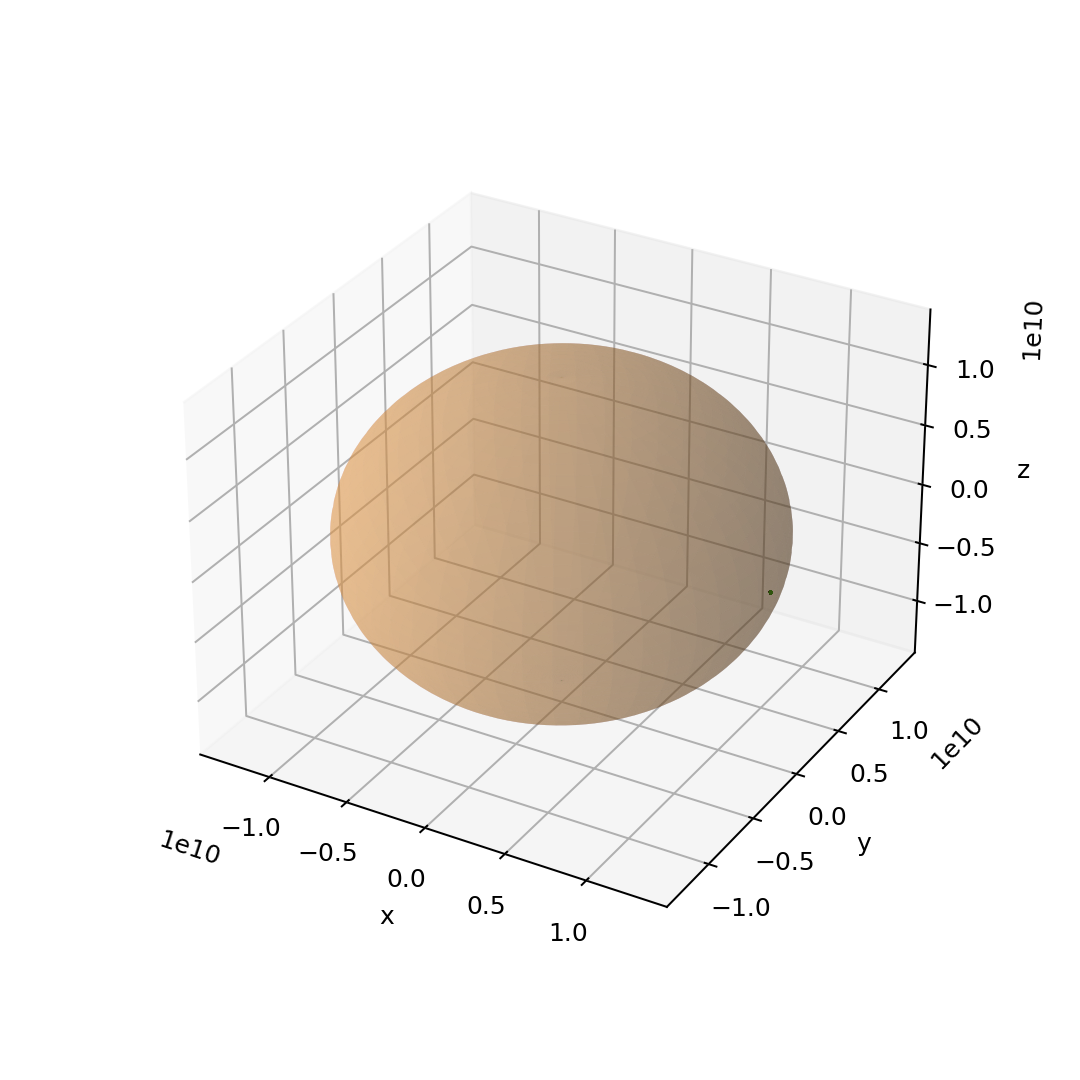

Inner horizon: 0.0
Outer horizon: 12690924327.937025
Inner ergosphere: [0.0,0.0]
Outer ergosphere: [12690924327.937025,12690924327.937025]


<IPython.core.display.Javascript object>


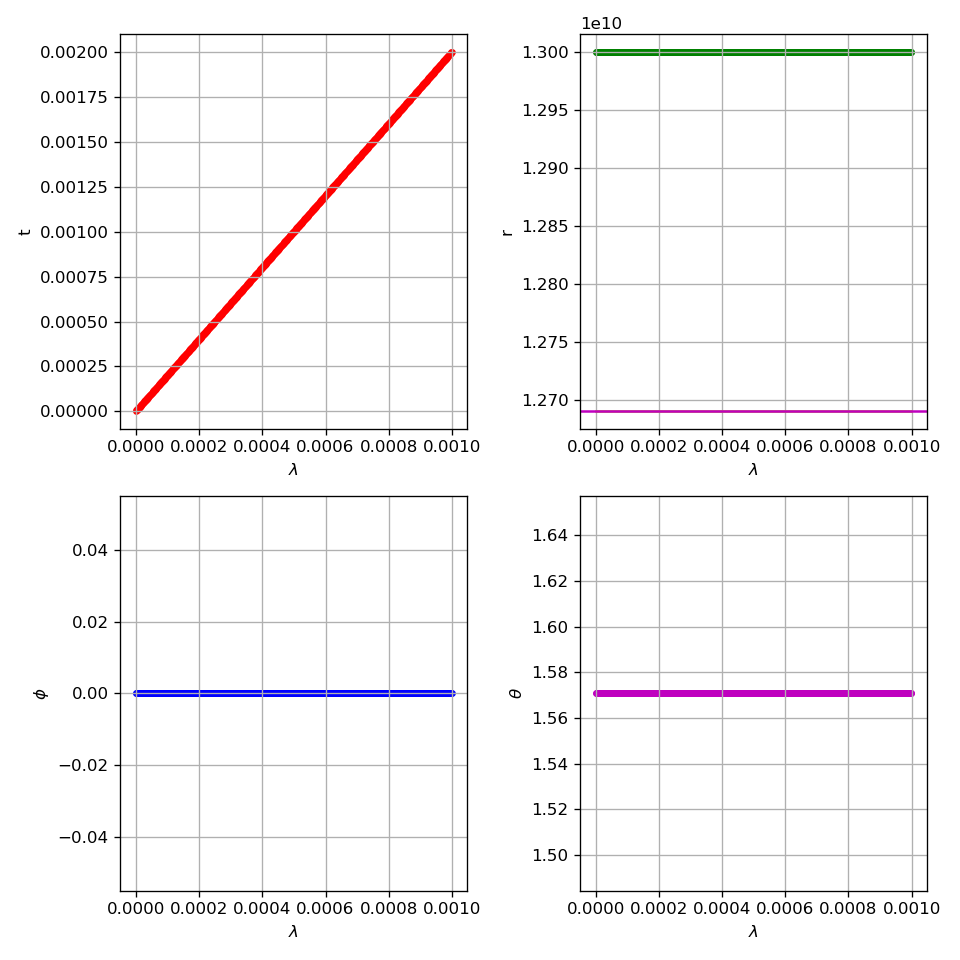

<IPython.core.display.Javascript object>


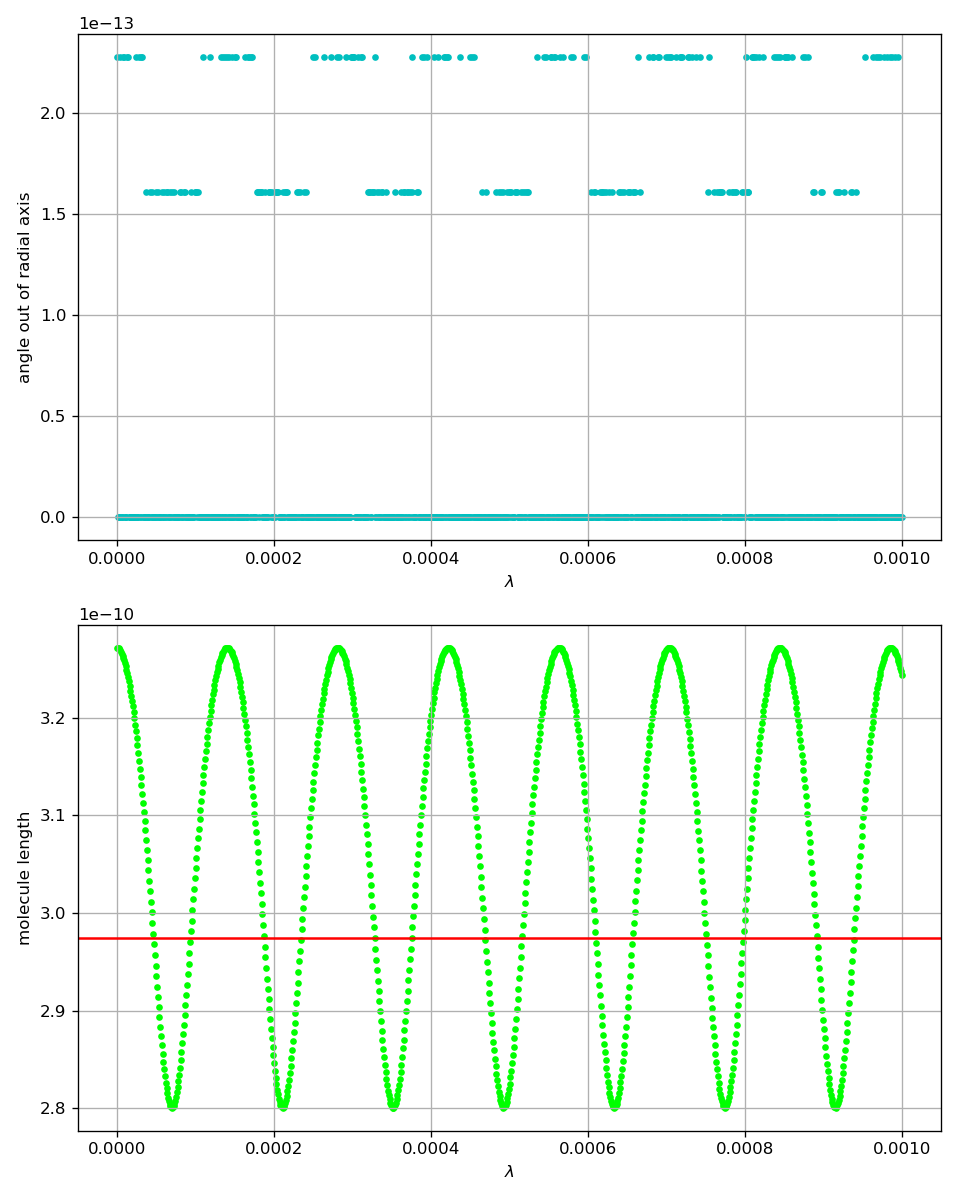

[mpf('13000000000.0') mpf('13000000000.00000000000001443')
 mpf('13000000000.0000000000000433') mpf('13000000000.00000000000008638')
 mpf('13000000000.00000000000014388') mpf('13000000000.00000000000021583')
 mpf('13000000000.0000000000003022') mpf('13000000000.00000000000040301')
 mpf('13000000000.00000000000051803') mpf('13000000000.00000000000064748')] [mpf('13000000000.0000000003271976') mpf('13000000000.00000000032718339')
 mpf('13000000000.00000000032715453') mpf('13000000000.00000000032711123')
 mpf('13000000000.00000000032705372') mpf('13000000000.00000000032698177')
 mpf('13000000000.0000000003268954') mpf('13000000000.00000000032679459')
 mpf('13000000000.00000000032667957') mpf('13000000000.00000000032655012')]


In [7]:
if __name__=='__main__':
    main()